#### **Construcción de un Modelo de Scoring de Comportamiento**

**Objetivo:** Crear un modelo que otorgue a cada cliente una puntuación para ordenar a los clientes de acuerdo con su calidad crediticia.


**Revisión y Análisis de los Datos**

**Librerías**

In [1]:
import pandas as pd
# from pyxlsb import open_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

### **1. Carga y Exploración de los Datos**

In [2]:
import pandas as pd
from pyxlsb import open_workbook

# Define la ruta al archivo .xlsb
file_path = './BBDD_Scoring.xlsb' 

# Inicializa una lista para almacenar los datos
data = []

# Lee el archivo y extrae las filas
with open_workbook(file_path) as wb:
    with wb.get_sheet(1) as sheet:  # Cambia "1" al índice correcto de la hoja si es necesario
        for row in sheet.rows():
            # Extrae los valores de cada fila
            data.append([item.v for item in row])

# Convierte los datos en un DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # Usa la primera fila como nombres de columnas

In [3]:
def grafico_dispersion_2_var(df, var1, var2):
    sns.scatterplot(data=df, x=var1, y=var2, hue='default')
    plt.show()

In [4]:
# Muestra las primeras filas para verificar la carga
df.head()

,Cliente,default,Edad,Sal_BurCto_Year,Dias_impago_hip,Dias_impago_hip_year,Dias_mora_hip_year,Ant_hipotecaria,Importe_impago_hip,Importe_impago_hip_year,...,Importe_mora_year,Dias_impago_mes,Dias_impago_tri,Dias_impago_year,Dias_impago_2year,Dias_mora,Dias_mora_tri,Dias_mora_year,Dias_mora_2year,Cuotas_ptmos
0,1.0,0.0,70.42,0.0,0.0,0.0,0.0,102.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,2.0,0.0,44.28,0.0,0.0,0.0,0.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,425.81
2,3.0,0.0,46.70,0.0,0.0,0.0,0.0,162.0,0.0,0.0,...,0.0,0.0,3.0,5.0,6.0,0.0,0.0,0.0,0.0,377.76
3,4.0,0.0,68.19,0.0,0.0,0.0,0.0,159.0,0.0,0.0,...,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,853.85
4,5.0,0.0,55.43,0.0,0.0,0.0,0.0,188.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Se ha decidido quitar las columnas que solo tienen un valor único, ya que no aportan información al modelo.

In [5]:
# calcular numero de valores distintos en cada columna
columnas_sin_valores_distintos = df.nunique()[df.nunique() < 2].index
df = df.drop(columnas_sin_valores_distintos, axis=1)
df

,Cliente,default,Edad,Sal_BurCto_Year,Dias_impago_hip_year,Dias_mora_hip_year,Ant_hipotecaria,Importe_impago_hip_year,Dias_imp_ptmopres_Tri,Importe_impago_ptmopers_year,...,Importe_impagado_year,Importe_mora_tri,Importe_mora_year,Dias_impago_tri,Dias_impago_year,Dias_impago_2year,Dias_mora_tri,Dias_mora_year,Dias_mora_2year,Cuotas_ptmos
0,1.0,0.0,70.42,0.0,0.0,0.0,102.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,2.0,0.0,44.28,0.0,0.0,0.0,108.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,425.81
2,3.0,0.0,46.70,0.0,0.0,0.0,162.0,0.00,0.0,0.0,...,154.99,0.0,0.00,3.0,5.0,6.0,0.0,0.0,0.0,377.76
3,4.0,0.0,68.19,0.0,0.0,0.0,159.0,0.00,0.0,0.0,...,50.56,0.0,0.00,0.0,4.0,4.0,0.0,0.0,0.0,853.85
4,5.0,0.0,55.43,0.0,0.0,0.0,188.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249428,249429.0,1.0,37.69,0.0,35.0,0.0,35.0,2819.09,0.0,0.0,...,2819.09,0.0,21.03,0.0,91.0,91.0,0.0,20.0,20.0,0.00
249429,249430.0,1.0,52.48,0.0,0.0,0.0,15.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,232.28
249430,249431.0,1.0,51.50,0.0,0.0,0.0,15.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,689.01
249431,249432.0,1.0,36.41,0.0,0.0,0.0,13.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,92.33


In [6]:
# 1. Exploración Inicial
print("Tipos de datos:\n", df.dtypes)
print("\nValores faltantes:\n", df.isnull().sum())

Tipos de datos:
 Cliente                          float64
default                          float64
Edad                             float64
Sal_BurCto_Year                  float64
Dias_impago_hip_year             float64
Dias_mora_hip_year               float64
Ant_hipotecaria                  float64
Importe_impago_hip_year          float64
Dias_imp_ptmopres_Tri            float64
Importe_impago_ptmopers_year     float64
Dias_impago_tarjeta_tri          float64
Dias_impago_tarjeta_year         float64
Dias_impago_tarjeta_2year        float64
Cuota_tarjetas                   float64
Indicador_tarjeta                float64
Dias_impago_descubierto_tri      float64
Dias_impago_descubierto_year     float64
Dias_impago_descubierto_2year    float64
Dias_mora_descubierto_2year      float64
Descubierto_year                 float64
Saldo_cta_coriente               float64
Saldo_total                      float64
Saldo_cta_corriente_tri          float64
Saldo_cta_corriente_year         float64

In [7]:
# 2. Resumen Estadístico
print("\nResumen estadístico:\n", df.describe())


Resumen estadístico:
              Cliente        default           Edad  Sal_BurCto_Year  \
count  249433.000000  249433.000000  249433.000000     2.494330e+05   
mean   124717.000000       0.001556      47.055684     1.433335e+02   
std     72005.249185       0.039410      10.938642     8.428254e+03   
min         1.000000       0.000000       6.110000     0.000000e+00   
25%     62359.000000       0.000000      39.190000     0.000000e+00   
50%    124717.000000       0.000000      44.950000     0.000000e+00   
75%    187075.000000       0.000000      53.630000     0.000000e+00   
max    249433.000000       1.000000     106.170000     3.707142e+06   

       Dias_impago_hip_year  Dias_mora_hip_year  Ant_hipotecaria  \
count         249433.000000       249433.000000    249433.000000   
mean               1.004498            0.971058       120.022367   
std                8.268045           41.418899        61.009153   
min                0.000000            0.000000         0.000000 

In [33]:
# 3. Distribución de variables categóricas (columna'default')
print("\nDistribución de valores categóricos:")
print(df['default'].value_counts())
print(len(df[df['default'] == 1.0]) / len(df) * 100)


Distribución de valores categóricos:
0.0    249045
1.0       388
Name: default, dtype: int64
0.15555279373619368


Creación de variables

In [9]:
df['saldo_<_30k'] = (df['Saldo_total'] < 30000).astype(int)

# tabla con porcentaje de cantidad de personas con saldo menor a 30k y default
tabla = df.groupby('default')['saldo_<_30k'].value_counts(normalize=True).unstack()
display(tabla) # significa que el 97% de las personas con saldo menor a 30k han entrado en default y solo el 

tabla2 = df.groupby('saldo_<_30k')['default'].value_counts(normalize=True).unstack()
display(tabla2)

saldo_<_30k,0,1
default,,
0.0,0.189171,0.810829
1.0,0.033505,0.966495


default,0.0,1.0
saldo_<_30k,,
0,0.999724,0.000276
1,0.998146,0.001854


In [35]:
df.loc[df['Ingresos_totales'] == 0, 'Ingresos_totales'] = 1
df['Gastos/Ingresos'] = df['Gastos'] / df['Ingresos_totales']
df['Cuotas_ptmos/Ingresos'] = df['Cuotas_ptmos'] / df['Ingresos_totales']
df['Recibos_denegados_dummy'] = (df['Recibos_denegados'] > 0).astype(int)
df['Ant_hipotecaria_>_100'] = (df['Ant_hipotecaria'] > 100).astype(int)

**Variables de interés**

In [36]:
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

**Análisis Univariante**

Este análisis examina cada variable individualmente, proporcionando una visión general de la distribución de cada variable. Esto incluye el cálculo de estadísticas descriptivas (como la media, mediana, varianza) y la visualización de su distribución (con histogramas, boxplots, etc.). En el caso de nuestro análisis de calidad crediticia, este paso es fundamental para entender las características de los datos, como valores atípicos, asimetrías y posibles problemas de calidad.

**Variables**

Para el análisis inicial, sugeriría enfocarnos en las variables más relacionadas con el historial de incumplimiento, los importes de impago, los ingresos/gastos y los saldos de cuentas. Podríamos comenzar con el siguiente conjunto de variables para el análisis univariante y bivariante:

In [37]:
# Obtener el resumen estadístico de todas las columnas numéricas
# df.describe().transpose()

In [38]:
# Análisis Univariante: Visualización de distribuciones para variables numéricas


In [39]:
# Test T para variables numéricas según 'default'
columnas = list(df.columns)

for col in columnas:
    group0 = df[df['default'] == 0][col]
    group1 = df[df['default'] == 1][col]
    stat, p_value = ttest_ind(group0, group1, equal_var=False)
    
    # Condición para mostrar solo los p-valores menores a 0.05
    if p_value < 0.05:
        print(f"Variable: {col} - p-value: {p_value:.10f}")
        

    # Si el p-valor es bajo (por ejemplo, menor a 0.05), sugiere que hay una diferencia significativa entre los 
    # dos grupos para esa variable numérica, lo que significa que el valor de la variable es significativamente diferente 
    # según el valor de default.

Variable: Cliente - p-value: 0.0000000000
Variable: default - p-value: 0.0000000000
Variable: Edad - p-value: 0.0000014903
Variable: Sal_BurCto_Year - p-value: 0.0005885390
Variable: Dias_impago_hip_year - p-value: 0.0000000000


C:\Users\unaim\AppData\Local\Temp\ipykernel_12800\2591759836.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, p_value = ttest_ind(group0, group1, equal_var=False)


Variable: Dias_mora_hip_year - p-value: 0.0397989138
Variable: Ant_hipotecaria - p-value: 0.0081635760
Variable: Importe_impago_hip_year - p-value: 0.0000000002
Variable: Dias_imp_ptmopres_Tri - p-value: 0.0000000276
Variable: Dias_impago_tarjeta_year - p-value: 0.0028469075
Variable: Dias_impago_tarjeta_2year - p-value: 0.0006418102
Variable: Cuota_tarjetas - p-value: 0.0000000000
Variable: Indicador_tarjeta - p-value: 0.0000000000
Variable: Dias_impago_descubierto_tri - p-value: 0.0000000000
Variable: Dias_impago_descubierto_year - p-value: 0.0000000000
Variable: Dias_impago_descubierto_2year - p-value: 0.0000000000
Variable: Dias_mora_descubierto_2year - p-value: 0.0057565623
Variable: Descubierto_year - p-value: 0.0000000000
Variable: Saldo_cta_coriente - p-value: 0.0000000000
Variable: Saldo_total - p-value: 0.0000000000
Variable: Saldo_cta_corriente_tri - p-value: 0.0000000000
Variable: Saldo_cta_corriente_year - p-value: 0.0000000000
Variable: Saldo_depositos_tri - p-value: 0.00

**Análisis Bivariante**

In [40]:
# Correlación entre variables --> TODAS

# Umbral de correlación
umbral = 0.7  # Puedes ajustar este valor según lo que consideres relevante

# Calcular la matriz de correlaciones
corr_matrix = df.corr()

# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix = corr_matrix.where(np.abs(corr_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix = filtered_corr_matrix.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix = filtered_corr_matrix[filtered_corr_matrix['Variable_1'] != filtered_corr_matrix['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).drop_duplicates('Correlacion')

,Variable_1,Variable_2,Correlacion
0,Edad,Edad_round,0.999644
2,Saldo_total_tri,Saldo_total,0.994641
4,Ant_hipotecaria,Antig_cdto,0.993897
6,Importe_impago_hip_year,Importe_impagado_year,0.989843
8,Saldo_cta_coriente,Saldo_cta_corriente_tri,0.984173
10,Saldo_total_tri,Saldo_total_year,0.982182
12,Saldo_total_year,Saldo_total,0.973076
14,Saldo_cta_corriente_year,Saldo_cta_corriente_tri,0.956321
16,Recibos_domi_sem,Recibos_domi_tri,0.943654
18,Ingresos_totales,Ingresos_nomina,0.934830


<AxesSubplot: xlabel='Edad_round'>

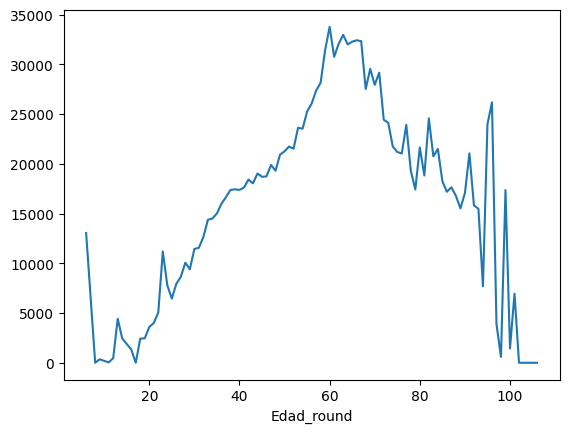

In [41]:
df['Edad_round'] = df['Edad'].round()
df.groupby('Edad_round')['Saldo_total'].mean().plot()

## **FALTA**

In [42]:
# MIRAR CORRELACION ENTRE EDAD Y DEFAULT Y COMPARAR CON GRAFICO DE ARRIBA
# ANTIGUEDAD CREDITO Y DEFAULT


## **IDEAS**

In [43]:
# IMPLEMENTAR UNDERSAMPLING PARA QUE EL MODELO APRENDA SOBRE TODO DE LOS QUE HAN ENTRADO EN DEFAULT

In [44]:
df['Ant_hipotecaria_>_100'].value_counts()

1    158000
0     91433
Name: Ant_hipotecaria_>_100, dtype: int64

In [45]:
df.groupby(['Edad_round', 'Ant_hipotecaria_>_100'])['default'].value_counts(normalize=True).unstack().head(20)#.plot(kind='bar', stacked=True)

default                           0.0  1.0
Edad_round Ant_hipotecaria_>_100          
6.0        0                      1.0  NaN
8.0        0                      1.0  NaN
9.0        0                      1.0  NaN
11.0       0                      1.0  NaN
12.0       0                      1.0  NaN
13.0       0                      1.0  NaN
14.0       0                      1.0  NaN
           1                      1.0  NaN
16.0       0                      1.0  NaN
17.0       0                      1.0  NaN
18.0       0                      1.0  NaN
19.0       0                      1.0  NaN
20.0       0                      1.0  NaN
21.0       0                      1.0  NaN
           1                      1.0  NaN
22.0       0                      1.0  NaN
23.0       0                      1.0  NaN
           1                      1.0  NaN
24.0       0                      1.0  NaN
25.0       0                      1.0  NaN

In [46]:
# grafico_dispersion_2_var(df, 'Ant_hipotecaria', 'Edad')

In [47]:
df.groupby('Importe_impago_hip_year')['default'].value_counts(normalize=True).unstack().head(20)

default,0.0,1.0
Importe_impago_hip_year,,
0.00,0.999224,0.000776
0.01,1.000000,NaN
0.02,1.000000,NaN
0.03,1.000000,NaN
0.04,1.000000,NaN
0.05,1.000000,NaN
0.06,1.000000,NaN
0.08,1.000000,NaN
0.09,1.000000,NaN


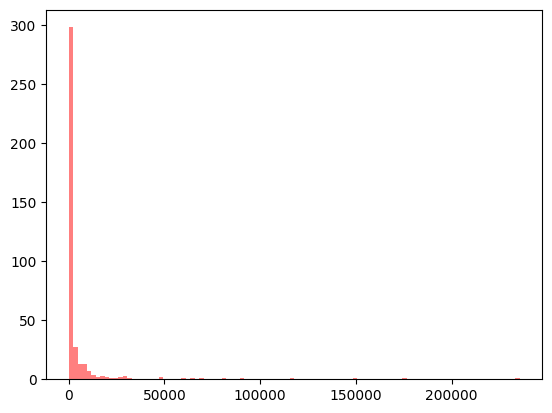

In [48]:
plt.hist(df.loc[df['default'] == 1, 'Saldo_total'], bins=100, color='red', alpha=0.5, label='Default = 1');

In [49]:
# Obtener las correlaciones con 'default' de la matriz de correlación --> CORRELACIONES 'DEFAULT'
default_corr = corr_matrix['default'].sort_values(ascending=False)

# Mostrar las correlaciones con 'default', excluyendo la diagonal (correlación de 'default' consigo mismo)
default_corr = default_corr[default_corr.index != 'default']

# Mostrar los resultados
default_corr

Dias_impago_descubierto_year     0.124999
Dias_impago_descubierto_2year    0.119540
Dias_impago_tri                  0.115121
Dias_impago_2year                0.112001
Dias_impago_year                 0.109373
Dias_impago_descubierto_tri      0.102896
Dias_impago_hip_year             0.084334
Mora_ult5A                       0.079127
Cliente                          0.068259
Dias_mora_2year                  0.043143
Dias_impago_tarjeta_tri          0.040390
Dias_mora_year                   0.039604
Descubierto_year                 0.037927
Dias_impago_tarjeta_year         0.036175
Recibos_denegados                0.035334
Dias_mora_hip_year               0.034330
Recibos_denegados_dummy          0.032205
Dias_impago_tarjeta_2year        0.029436
Dias_mora_tri                    0.023816
Importe_impagado_tri             0.023717
Dias_mora_descubierto_2year      0.019385
Cuotas_ptmos/Ingresos            0.017959
saldo_<_30k                      0.015672
Edad                             0

In [50]:
# Correlación con las variables de interés (están puestas en el doc, pq son de interés)

# Lista de variables de interés
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

# Filtrar el dataset solo con las variables de interés
df_filtered = df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Umbral de correlación
umbral = 0.1  # Puedes ajustar este valor según lo que consideres relevante


# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix2 = correlation_matrix.where(np.abs(correlation_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix2 = filtered_corr_matrix2.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix2.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix2 = filtered_corr_matrix2[filtered_corr_matrix2['Variable_1'] != filtered_corr_matrix2['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix2.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

,Variable_1,Variable_2,Correlacion
0,Saldo_cta_corriente_year,Saldo_total,0.684352
1,Saldo_total,Saldo_cta_corriente_year,0.684352
2,Dias_impago_hip_year,Dias_impago_descubierto_year,0.323623
3,Dias_impago_descubierto_year,Dias_impago_hip_year,0.323623
4,Gastos,Ingresos_totales,0.276827
5,Ingresos_totales,Gastos,0.276827
6,Mora_ult5A,Dias_impago_descubierto_year,0.272732
7,Dias_impago_descubierto_year,Mora_ult5A,0.272732
8,Dias_impago_hip_year,Dias_mora_hip_year,0.255230
9,Dias_mora_hip_year,Dias_impago_hip_year,0.255230


In [51]:
# Obtener las correlaciones con 'default' de la matriz de correlación --> CORRELACIONES 'DEFAULT'
default_corr2 = correlation_matrix['default'].sort_values(ascending=False)

# Mostrar las correlaciones con 'default', excluyendo la diagonal (correlación de 'default' consigo mismo)
default_corr2 = default_corr2[default_corr2.index != 'default']

# Mostrar los resultados
default_corr2

Dias_impago_descubierto_year    0.124999
Dias_impago_hip_year            0.084334
Mora_ult5A                      0.079127
Dias_mora_hip_year              0.034330
Edad                            0.011128
Gastos                         -0.010251
Saldo_total                    -0.013254
Saldo_cta_corriente_year       -0.016172
Ingresos_totales               -0.018735
Name: default, dtype: float64

**Posibles Transformaciones**

### **2. Construcción del Modelo de Clasificación**

Convendría poner restricciones del tipo de quedarse con las **variables más influyentes** en el modelo, más del 5% estaría bien. Entre **6-15 variables.**

**Modelo interpretable**

In [52]:
# Dividir en variables predictoras (X) y objetivo (y)
X = df.drop(columns=['Cliente', 'default'])
y = df['default']

# Identificar variables categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns


# Convertir variables categóricas a numéricas (si las hubiera)
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Normalizar o estandarizar las variables numéricas (opcional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 3. Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [54]:
# 4. Evaluación del modelo
y_pred = rf_model.predict(X_test)

# Reporte de clasificación (precisión, recall, F1 score)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     74719
         1.0       1.00      0.06      0.12       111

    accuracy                           1.00     74830
   macro avg       1.00      0.53      0.56     74830
weighted avg       1.00      1.00      1.00     74830



In [55]:
# # Matriz de confusión
# conf_matrix = confusion_matrix(y_test, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.title("Matriz de Confusión")
# plt.xlabel("Predicción")
# plt.ylabel("Realidad")
# plt.show()

In [56]:
# 5. Importancia de las variables
importances = rf_model.feature_importances_
feature_names = X.columns

# Crear un DataFrame con la importancia de cada variable
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las variables más influyentes
print("\nVariables más influyentes:")
print(importance_df.head(10))


Variables más influyentes:
                     Feature  Importance
18        Saldo_cta_coriente    0.043495
0                       Edad    0.042397
50              Cuotas_ptmos    0.042185
20   Saldo_cta_corriente_tri    0.041991
23           Saldo_total_tri    0.041912
19               Saldo_total    0.040320
24          Saldo_total_year    0.039188
41     Importe_impagado_year    0.039073
21  Saldo_cta_corriente_year    0.038135
39                Antig_cdto    0.038105


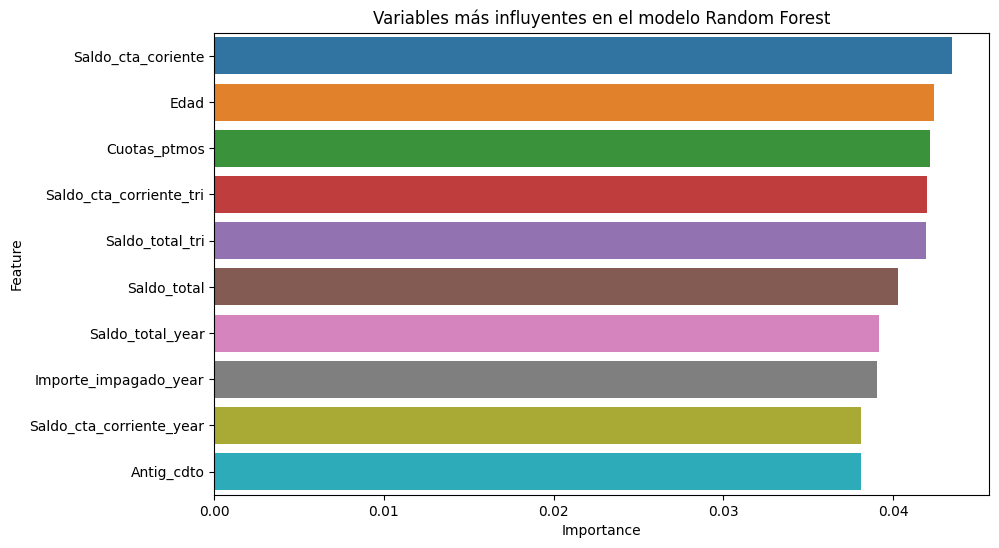

In [57]:
# Visualizar las variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Variables más influyentes en el modelo Random Forest')
plt.show()

**Modelo Caja Negra**